### Noise Addition

We can add sample noise $Z \sim D^n$ to each initial data. The noise comes from Normal and Laplace distributions. After that we can calculate the statistic:

$\hat{H} = H + Z$

$$ M_{\sigma} = \Pi (\mathrm{diag}(p^0 + \sigma) - p^0 (p^0)^T)^{-1}) \Pi, \quad $$


$$\Pi = I_d  - \frac{1}{d} \mathbb{1} \mathbb{1}^T$$


$$ T_{KR}^{(n)} (\sigma; D) = n \cdot \left(\frac{\hat{H}}{n} - p^0\right)^T \,\, M_{\sigma} \,\, \left(\frac{\hat{H}}{n} - p^0\right)$$



In [ ]:
def sigma_matrix(p_0, sigma, d):
    Id = np.eye(d)
    IId = np.ones((d,d))/d
    Projection_matrix = (Id - IId)
    diag_matrix = np.diag(p_0) + np.eye(d)*sigma
    M = Projection_matrix @ np.linalg.inv(diag_matrix - np.outer(p_0, p_0)) @ Projection_matrix
    return(M)


def noise_norm(x, p, alpha, p_0):
    H = np.sum(x, axis = 0)
    n = len(x)
    dim = len(H)
    D = np.random.normal(0, np.sqrt(len(x)/p), dim)
    H_noise = H + D
    q = n * (H_noise/n - p_0).values.reshape(1, -1) @ sigma_matrix(p_0, n / p, dim) @ (H_noise/n - p_0).values.reshape(-1,1)
    if q > chi2(dim-1).ppf(1 - alpha):
        return(1)
    else:
        return(0)

def noise_lap(x, alpha, p_0, eps):
    H = np.sum(x, axis = 0)
    D = np.sum(np.random.laplace(0, 2 / eps, size=(len(x),len(H))), axis = 0)
    H_noise_lap = H + D
    M_s = sigma_matrix(p_0, 8 * len(x) / eps **  2, len(H))
    q = len(x) * (H_noise_lap/len(x) - p_0).values.reshape(1, -1) @ sigma_matrix(p_0, 8 * len(x) / eps ** 2, len(H)) @ (H_noise_lap/len(x) - p_0).values.reshape(-1,1)
    ar = []
    for i in range(50):
        x0 = np.random.multinomial(1, p_0, size=len(x))
        H0 = np.sum(x0, axis = 0)
        D = np.sum(np.random.laplace(0, 2/eps, size=(len(x),len(H))), axis=0)
        H_noise_lap = H0 + D
        ar.append(len(x)* (H_noise_lap/len(x) - p_0).reshape(1, -1) @ sigma_matrix(p_0, 8 * len(x)/ eps ** 2, len(H)) @ (H_noise_lap/len(x) - p_0).reshape(-1, 1))
    ar = np.sort(ar)
    l = len(ar)+1
    v = (1-alpha)
    if q > ar[int((l) * v - 1)]:
        return(1)
    else:
        return(0)

In [11]:
import numpy as np
import scipy.stats as sps

import statsmodels as sm
import statsmodels.api as sma
from scipy.stats import bernoulli

import random
import math
import pandas as pd

from tqdm import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt


def generate_data(dims, n, p_0, eta):
    
    p1 = []
    for h in range(len(p_0)):
        p1.append(p_0[0] + eta * (-1)**(h+2))
    data = pd.DataFrame(np.empty((int(n), int(dims))))
    
    for i in range(n):
        data.iloc[i, :] = np.random.multinomial(1, p1, size=1)
    return data

def process(params):
    epsilon, dims, p_0, n, eta = params[0], params[1], params[2], int(params[3]), params[4]
    data = generate_data(dims=dims, n=n, p_0=p_0, eta=eta)
    return noise_lap(data, 0.05, [1/dims]*dims, epsilon)


def calculate_power(trials,epsilon, dims, p_0, n, eta):
    params = [epsilon, dims, p_0, n, eta]
    params = [params] * trials
    res = Parallel(n_jobs=8)(delayed(process)(params) for params in tqdm(params))
    return sum(res) / trials

In [12]:
dims=4
eta=0.01
p_0=np.array([1 / dims] * dims)

n_vector = np.linspace(300, 30000, 10)
results = pd.DataFrame(np.empty((3,len(n_vector))))

i = 0
j = 0

for e in [1,2,4]:
    for n in n_vector:
        results.iloc[i,j] = calculate_power(trials=100, epsilon=e, dims=int(dims), p_0=p_0, n=int(n), eta=eta)
        j+=1
    i+=1
    j=0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [18:59<00:59, 12.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


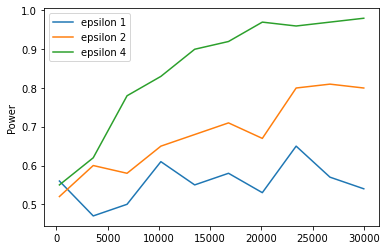

In [13]:
results.columns = n_vector
plt.plot(results.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.ylabel('Power')
plt.legend()